In [15]:
import numpy as np
import matplotlib.pyplot as plt
from wasp import wasp
from wasp_val import wasp_val

In [16]:
# === Synthetic Data ===
# Parameters
N = 128
N_fc = 24
n_var = 4
fs = 50
dt = 1 / fs
t = np.arange(0, N + N_fc) * dt

# Set seed for reproducibility
seed = 20250425  # You can choose any integer
np.random.seed(seed)

Y_ALL = (np.sin(2 * np.pi * t + np.random.randn(1)) + 0.1 * np.random.randn(len(t))).flatten()
X = np.random.randn(N + N_fc, n_var)
Y = Y_ALL[:N]
Y_val = Y_ALL[N:]

In [17]:
# === Wavelet Settings ===
n_vanish = 2
wname = f'db{n_vanish}'
flag_sign = True
method = 'dwtmra'

# === Decomposition level ===
# maximum decomposition level: floor(log2(size(X,1)))
# or rule of thumb decomposition level: ceiling(log(n/(2*v-1))/log(2))-1 (Kaiser, 1994)
# lev = int(np.floor(np.log2(X.shape[0])) - 1)
lev = int(np.ceil(np.log(X.shape[0] / (2 * n_vanish - 1)) / np.log(2))) - 1
# max_level = pywt.dwt_max_level(X.shape[0], pywt.Wavelet(wname).dec_len)  
# print(max_level)
print("Decomposition level: ", lev)

Decomposition level:  5


In [18]:
# === WASP Transformation ===
X_WaSP, C = wasp(Y, X, method=method, wavelet_name=wname, level=lev, flag_sign=flag_sign)


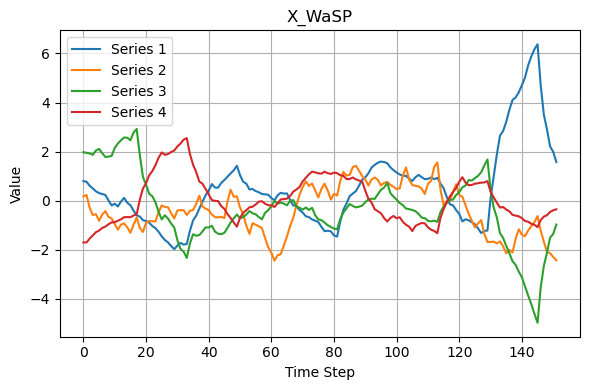

In [19]:
time_steps, num_series = X_WaSP.shape
time = np.arange(time_steps)

plt.figure(figsize=(6, 4))
for i in range(num_series):
    plt.plot(time, X_WaSP[:, i], label=f"Series {i+1}")

plt.title("X_WaSP")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# === Calibration: Linear Models & RMSE ===
RMSE = np.full(n_var, np.nan)
RMSE_WaSP = np.full(n_var, np.nan)
RMSE_opti = np.full(n_var, np.nan)
p_coeff1_all = []
p_coeff2_all = []

In [21]:
for i in range(n_var):
    x_cal = X[:N, i]
    x_wasp_cal = X_WaSP[:N, i]
    
    ratio = np.var(x_cal) / np.var(x_wasp_cal)
    RMSE_opti[i] = np.sqrt((np.var(Y) - (np.linalg.norm(C[:, i]) ** 2) * ratio))

    p1 = np.polyfit(x_cal, Y, 1)
    p_coeff1_all.append(p1)
    Y_fit1 = np.polyval(p1, x_cal)
    RMSE[i] = np.sqrt(np.mean((Y - Y_fit1) ** 2))

    p2 = np.polyfit(x_wasp_cal, Y, 1)
    p_coeff2_all.append(p2)
    Y_fit2 = np.polyval(p2, x_wasp_cal)
    RMSE_WaSP[i] = np.sqrt(np.mean((Y - Y_fit2) ** 2))

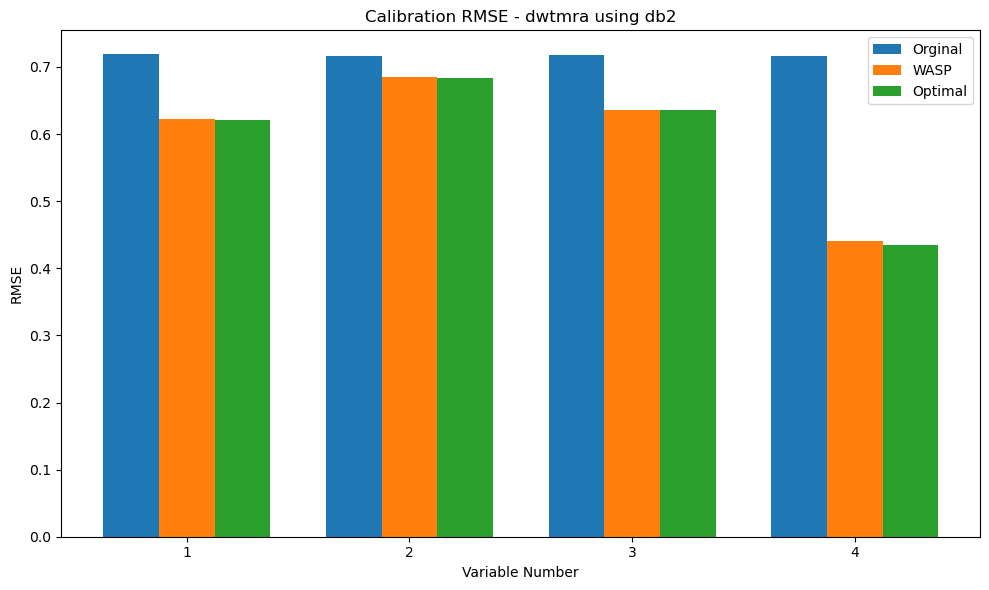

In [22]:
# === RMSE Bar Plot ===
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(n_var)

plt.bar(index, RMSE, bar_width, label='Orginal')
plt.bar(index + bar_width, RMSE_WaSP, bar_width, label='WASP')
plt.bar(index + 2 * bar_width, RMSE_opti, bar_width, label='Optimal')

plt.xlabel('Variable Number')
plt.ylabel('RMSE')
plt.title(f'Calibration RMSE - {method} using {wname}')
plt.xticks(index + bar_width, [str(i+1) for i in index])  # Set x-axis labels as 1, 2, 3, 4
plt.legend()
plt.tight_layout()
plt.savefig('RMSE_cal.png', dpi=300)

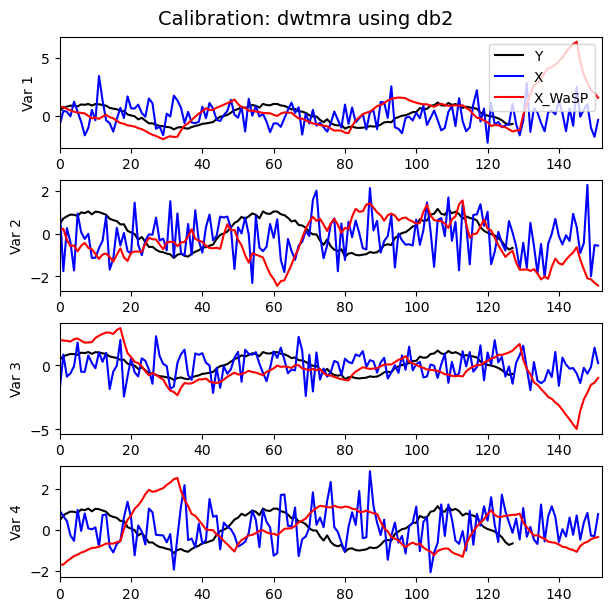

In [23]:
# === Calibration Comparison Plot ===
fig, axs = plt.subplots(n_var, 1, figsize=(6, 1.5 * n_var), constrained_layout=True)
fig.suptitle(f'Calibration: {method} using {wname}', fontsize=14)

for i in range(n_var):
    axs[i].plot(Y, 'k', label='Y')
    axs[i].plot(X[:, i], 'b', label='X')
    axs[i].plot(X_WaSP[:, i], 'r', label='X_WaSP')
    axs[i].set_xlim([0, N + N_fc])
    axs[i].set_ylabel(f'Var {i+1}')
    if i == 0:
        axs[i].legend(loc='upper right')

plt.savefig('Comparison_Calibration.png', dpi=300)

In [24]:
# === Validation Step ===
X_val = X[N:, :]
X_WaSP_val = wasp_val(X_val, C, method=method, wavelet_name=wname, flag_sign=flag_sign)

/Users/zejiang/miniconda3/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


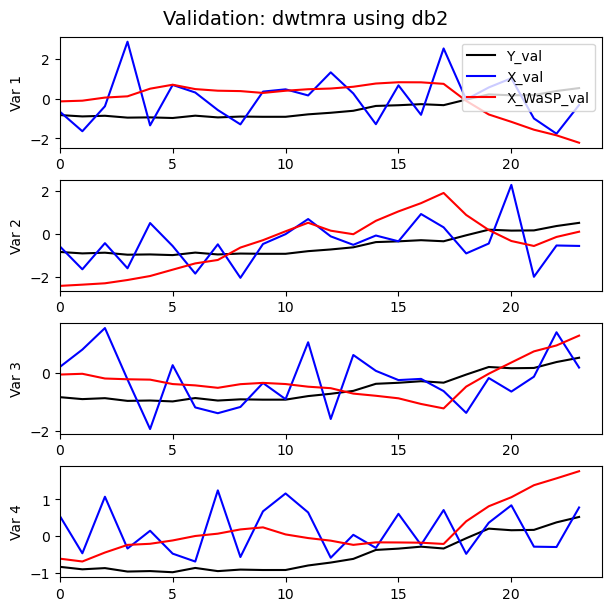

In [25]:
if N_fc > 0:
    # === Validation Signal Plot ===
    fig, axs = plt.subplots(n_var, 1, figsize=(6, 1.5 * n_var), constrained_layout=True)
    fig.suptitle(f'Validation: {method} using {wname}', fontsize=14)

    for i in range(n_var):
        axs[i].plot(Y_val, 'k', label='Y_val')
        axs[i].plot(X_val[:, i], 'b', label='X_val')
        axs[i].plot(X_WaSP_val[:, i], 'r', label='X_WaSP_val')
        axs[i].set_xlim([0, N_fc])
        axs[i].set_ylabel(f'Var {i+1}')
        if i == 0:
            axs[i].legend(loc='upper right')

    plt.savefig('Comparison_Validation.png', dpi=300)

    # === Forecast R² ===
    R_raw_fct = np.full(n_var, np.nan)
    R_WaSP_fct = np.full(n_var, np.nan)

    for i in range(n_var):
        y_pred_std = np.polyval(p_coeff1_all[i], X_val[:, i])
        y_pred_wasp = np.polyval(p_coeff2_all[i], X_WaSP_val[:, i])

        R_raw_fct[i] = np.corrcoef(Y_val, y_pred_std)[0, 1] ** 2
        R_WaSP_fct[i] = np.corrcoef(Y_val, y_pred_wasp)[0, 1] ** 2

[0.01024952 0.03627275 0.03115399 0.0002091 ]
[0.56514788 0.25717809 0.29017881 0.6785064 ]


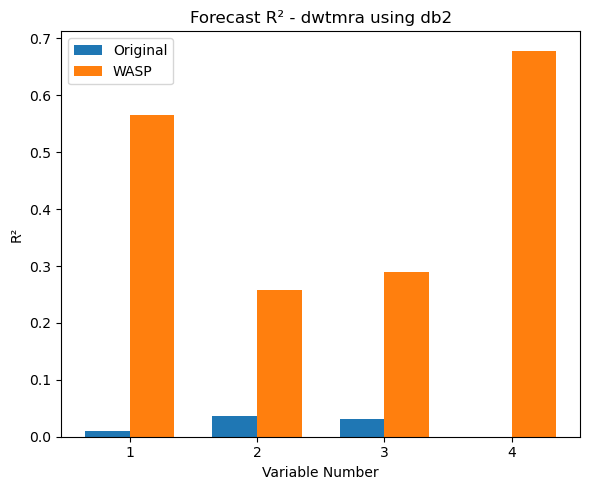

In [26]:
# === R² Bar Plot ===
print(R_raw_fct)
print(R_WaSP_fct)

plt.figure(figsize=(6, 5))
bar_width = 0.35
index = np.arange(n_var)
plt.bar(index, R_raw_fct, bar_width, label='Original')
plt.bar(index + bar_width, R_WaSP_fct, bar_width, label='WASP')
plt.xlabel('Variable Number')
plt.ylabel('R²')
plt.title(f'Forecast R² - {method} using {wname}')
plt.xticks(index + bar_width / 2, [str(i+1) for i in index])  # Set x-axis labels as 1, 2, 3, 4
plt.legend()
plt.tight_layout()
plt.savefig('R2_val.png', dpi=300)
